### Notebook for testing my code

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [35]:
my_path="data"
df=pd.read_csv(f"{my_path}/creditcard.csv")


### Modify Time variable:

In [36]:
df["Hours"] = df["Time"] // 3600

### Some fast visualizations

In [37]:
df.groupby('Class').size()
outlier_fraction = df['Class'].sum()/len(df)
print("proportion of frauds: ", outlier_fraction )
print("number of fraud transactions: ",df['Class'].sum())

proportion of frauds:  0.001727485630620034
number of fraud transactions:  492


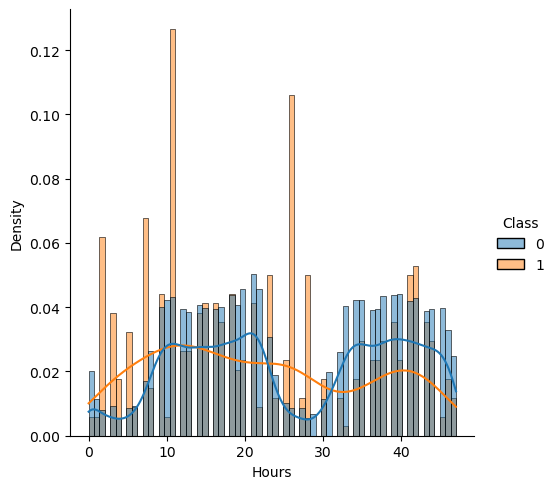

In [38]:
sns.displot(data=df,x='Hours',hue='Class', kde=True,stat='density', common_norm=False)

<Figure size 1000x600 with 0 Axes>

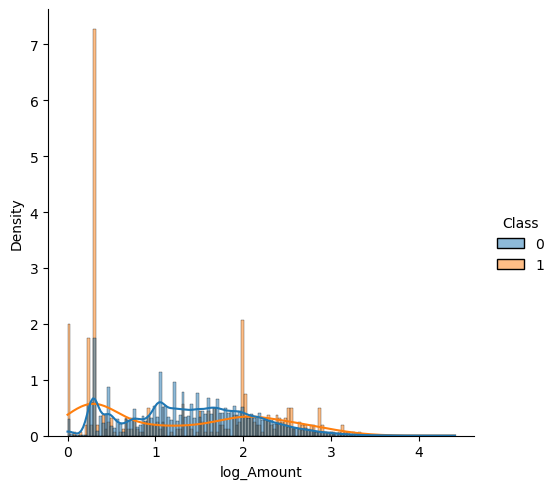

In [39]:
df["log_Amount"] = np.log10(df["Amount"] + 1)
plt.figure(figsize=(10,6))
sns.displot(data=df,x='log_Amount',hue='Class', kde=True,stat='density', common_norm=False)
plt.show()

### Split the data

In [40]:
x=df.drop(columns=["Class"])
y=df["Class"]
x_clean=x[y==0]
y_clean=y[y==0]
x_fraud=x[y==1]
y_fraud=y[y==1]
x_train, x_test, y_train, y_test = train_test_split(x_clean,y_clean,test_size=0.2, random_state=1)

In [41]:
x_test = pd.concat([x_test, x_fraud], axis=0)
y_test = pd.concat([y_test, y_fraud], axis=0)

###
For the following we want to predict 1 000 observations like possibly fraudulent transactions, so we use the `pourcent` as the `contamination` parameter in the Isolation Forest model.

In [42]:
predictict_outlier=1000
pourcent= predictict_outlier/len(x_test)
print("proportion of predicted outliers: ", pourcent)

proportion of predicted outliers:  0.01743527155435446


#### Isolation Forest

In [43]:
import importlib
from models import isolation_forest
from utils import evaluate_models
importlib.reload(isolation_forest)
importlib.reload(evaluate_models)
from models.isolation_forest import (
    train_isolation_forest,
    predict_isolation_forest
)     
from utils.evaluate_models import evaluate_model, print_evaluation

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
model = train_isolation_forest(x_train, contamination=pourcent,n_estimators=100)
y_pred_iso = predict_isolation_forest(model, x_test)
print_evaluation(evaluate_model(y_test, y_pred_iso))

Confusion Matrix:
[[55872   991]
 [  154   338]]

Classification Report:
Label 0:
  precision: 0.9973
  recall: 0.9826
  f1-score: 0.9899
  support: 56863.0000
Label 1:
  precision: 0.2543
  recall: 0.6870
  f1-score: 0.3712
  support: 492.0000
None


In [65]:
print(iso_res)

None


### SVM

In [46]:
import importlib
from models import svm
from utils import evaluate_models
importlib.reload(svm)
importlib.reload(evaluate_models)
from models.svm import (
    train_one_class_svm,
    predict_one_class_svm,
    train_sgd_one_class_svm,
    predict_sgd_one_class_svm
) 

### SVM one class 

In [ ]:
model = train_one_class_svm(x_train, nu=0.01, kernel='rbf', gamma='scale')
y_pred_svm = predict_one_class_svm(model, x_test)
print_evaluation(evaluate_model(y_test, y_pred_svm))

Confusion Matrix:
[[56147   716]
 [   84   408]]

Classification Report:
Label 0:
  precision: 0.9985
  recall: 0.9874
  f1-score: 0.9929
  support: 56863.0000
Label 1:
  precision: 0.3630
  recall: 0.8293
  f1-score: 0.5050
  support: 492.0000
None


### SGD One Class SVM

In [ ]:
model = train_sgd_one_class_svm(x_train, nu=0.01)
y_pred_svm_sgd = predict_sgd_one_class_svm(model, x_test)
print_evaluation(evaluate_model(y_test, y_pred_svm_sgd))

Confusion Matrix:
[[    0 56863]
 [    0   492]]

Classification Report:
Label 0:
  precision: 0.0000
  recall: 0.0000
  f1-score: 0.0000
  support: 56863.0000
Label 1:
  precision: 0.0086
  recall: 1.0000
  f1-score: 0.0170
  support: 492.0000
Confusion Matrix:
[[    0 56863]
 [    0   492]]

Classification Report:
Label 0:
  precision: 0.0000
  recall: 0.0000
  f1-score: 0.0000
  support: 56863.0000
Label 1:
  precision: 0.0086
  recall: 1.0000
  f1-score: 0.0170
  support: 492.0000
None


c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

### Local outlier factor

In [49]:
import importlib
from models import local_outiers_factor
from utils import evaluate_models
importlib.reload(local_outiers_factor)
importlib.reload(evaluate_models)
from models.local_outiers_factor import (
    train_local_outlier_factor,
    predict_local_outliers_factor
) 

In [ ]:
model=train_local_outlier_factor(x_train, n_neighbors=20, contamination=pourcent, novelty=False)
y_pred_lof = predict_local_outliers_factor(model, x_test) 
print_evaluation(evaluate_model(y_test, y_pred_lof))


Confusion Matrix:
[[55888   975]
 [  467    25]]

Classification Report:
Label 0:
  precision: 0.9917
  recall: 0.9829
  f1-score: 0.9873
  support: 56863.0000
Label 1:
  precision: 0.0250
  recall: 0.0508
  f1-score: 0.0335
  support: 492.0000
None


### Auto Encoder


In [51]:
X_train, X_validate = train_test_split(x_train, 
                                       test_size=0.20, 
                                       random_state=123)

In [52]:
import torch
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
x_val_tensor   = torch.tensor(X_validate, dtype=torch.float32)

In [53]:
import models.auto_encoder as auto_encoder
importlib.reload(auto_encoder)
from models.auto_encoder import (
    Autoencoder,
    fit
)

In [54]:
model = Autoencoder(input_dim=x_train_tensor.shape[1], encoding_dim=2)
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [55]:
len(x_train_tensor)

181961

In [ ]:
fit(
    model,
    loss_fn,
    optimizer,
    x_train_tensor,
    x_val_tensor,
    epochs=100,
    batch_size=256
)

In [70]:
model.eval()
with torch.no_grad():
    x_val_hat = model(x_val_tensor.to(next(model.parameters()).device)).cpu()
mse_val = ((x_val_hat - x_val_tensor)**2).mean(dim=1).numpy()
threshold = np.quantile(mse_val, 0.989)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
with torch.no_grad():
    x_test_hat = model(x_test_tensor.to(next(model.parameters()).device)).cpu()
mse_test = ((x_test_hat - x_test_tensor)**2).mean(dim=1).numpy()
y_pred = (mse_test > threshold).astype(int)   # 1 = anomalie

In [ ]:
confusion_matrix = evaluate_model(y_test, y_pred)
print_evaluation(confusion_matrix)


Confusion Matrix:
[[56264   599]
 [  122   370]]

Classification Report:
Label 0:
  precision: 0.9978
  recall: 0.9895
  f1-score: 0.9936
  support: 56863.0000
Label 1:
  precision: 0.3818
  recall: 0.7520
  f1-score: 0.5065
  support: 492.0000
None


In [75]:
confusion_matrix

{'confusion_matrix': array([[56264,   599],
        [  122,   370]]),
 'classification_report': {'0': {'precision': 0.9978363423544852,
   'recall': 0.9894659092907514,
   'f1-score': 0.9936334978675309,
   'support': 56863.0},
  '1': {'precision': 0.38183694530443757,
   'recall': 0.7520325203252033,
   'f1-score': 0.5065023956194388,
   'support': 492.0},
  'accuracy': 0.9874291692093105,
  'macro avg': {'precision': 0.6898366438294614,
   'recall': 0.8707492148079774,
   'f1-score': 0.7500679467434848,
   'support': 57355.0},
  'weighted avg': {'precision': 0.9925522049061611,
   'recall': 0.9874291692093105,
   'f1-score': 0.9894548124467991,
   'support': 57355.0}}}

### Resume of the results

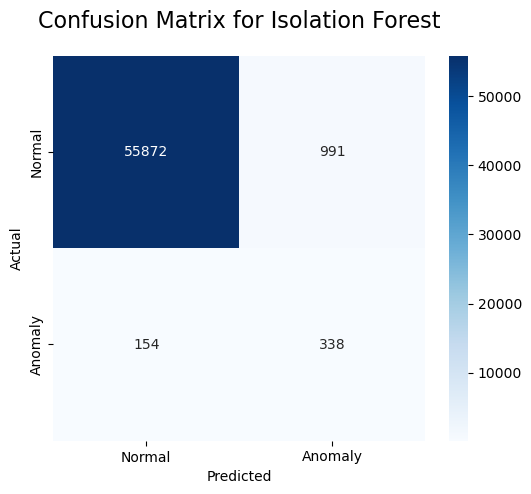

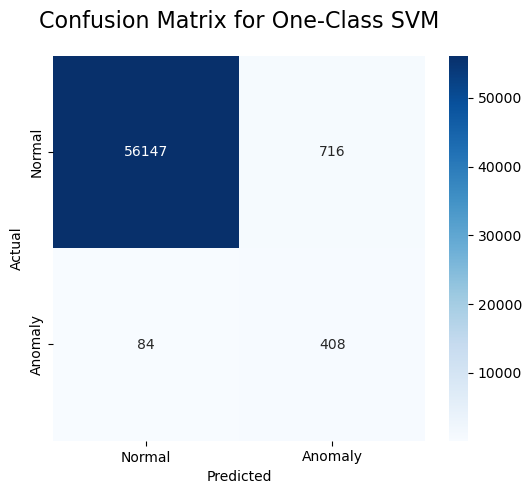

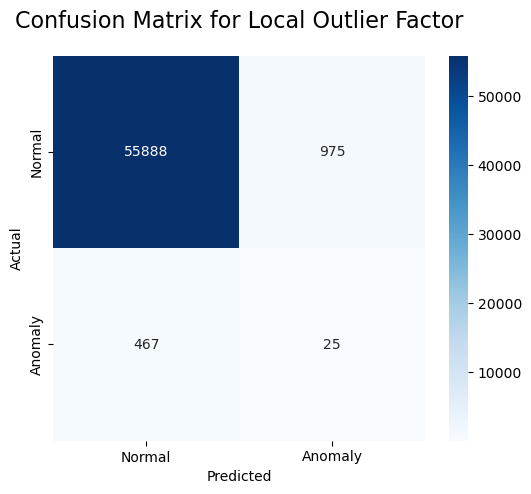

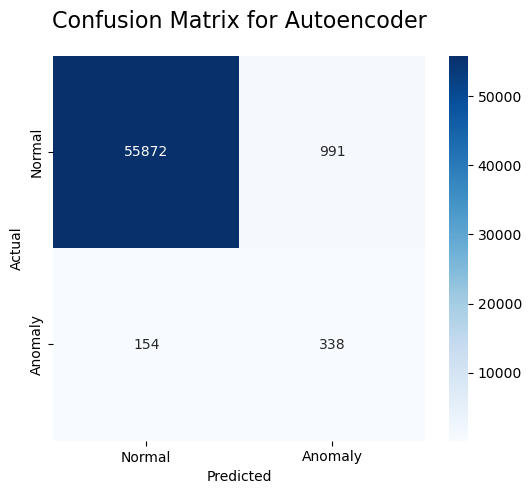

In [87]:
import utils.evaluate_models as evaluate_models
importlib.reload(evaluate_models)
from utils.evaluate_models import evaluate_model, print_evaluation, plot_confusion_matrix
for model_name, y_pred in [("Isolation Forest", y_pred_iso),
                       ("One-Class SVM", y_pred_svm),
                       ("Local Outlier Factor", y_pred_lof),
                       ("Autoencoder", y_pred)]:
    confusion_matrix = evaluate_model(y_test, y_pred)
    plot_confusion_matrix(confusion_matrix["confusion_matrix"], title=model_name)